In [25]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

In [26]:
import os
import sys
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

import keras.backend as K
# if len(K.tensorflow_backend._get_available_gpus()) > 0:
#   from keras.layers import CuDNNLSTM as LSTM
#   from keras.layers import CuDNNGRU as GRU

In [27]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

In [28]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join(r'C:\Users\Kirti\machine_learning_examples\glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM), encoding='utf-8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [29]:
# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv(r"C:\Users\Kirti\machine_learning_examples\nlp_class3\toxic_comment_train.csv", encoding='utf-8')
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values


Loading in comments...


In [30]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)


In [31]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [32]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)


Shape of data tensor: (159571, 100)


In [33]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector


Filling pre-trained embeddings...


In [34]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [17]:
np.__version__ 

'1.18.5'

In [ ]:
!pip install -U numpy==1.18.5

In [ ]:
numpy.__version__ 

In [18]:
print('Building model...')

# !pip install -U numpy==1.18.5
# !conda install numpy=1.19
# !pip install -U numpy==1.19.2
# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x)
# x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)

Building model...


In [19]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/5
998/998 [==============================] - 56s 56ms/step - loss: 0.0848 - accuracy: 0.9733 - val_loss: 0.0623 - val_accuracy: 0.9933
Epoch 2/5
998/998 [==============================] - 57s 57ms/step - loss: 0.0595 - accuracy: 0.9899 - val_loss: 0.0590 - val_accuracy: 0.9907
Epoch 3/5
998/998 [==============================] - 57s 57ms/step - loss: 0.0572 - accuracy: 0.9895 - val_loss: 0.0592 - val_accuracy: 0.9927
Epoch 4/5
998/998 [==============================] - 59s 59ms/step - loss: 0.0558 - accuracy: 0.9877 - val_loss: 0.0573 - val_accuracy: 0.9887
Epoch 5/5
998/998 [==============================] - 56s 56ms/step - loss: 0.0549 - accuracy: 0.9859 - val_loss: 0.0565 - val_accuracy: 0.9834


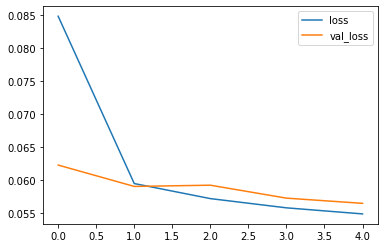

In [20]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


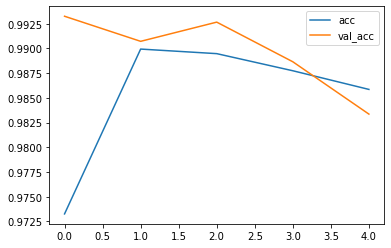

In [21]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [22]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9717938936854092


In [35]:
print('Building model...')

# !pip install -U numpy==1.18.5
# !conda install numpy=1.19
# !pip install -U numpy==1.19.2
# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)

Building model...


In [36]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/5
998/998 [==============================] - 66s 66ms/step - loss: 0.0722 - accuracy: 0.9735 - val_loss: 0.0575 - val_accuracy: 0.9930
Epoch 2/5
998/998 [==============================] - 70s 70ms/step - loss: 0.0552 - accuracy: 0.9854 - val_loss: 0.0553 - val_accuracy: 0.9881
Epoch 3/5
998/998 [==============================] - 79s 79ms/step - loss: 0.0528 - accuracy: 0.9821 - val_loss: 0.0542 - val_accuracy: 0.9758
Epoch 4/5
998/998 [==============================] - 78s 78ms/step - loss: 0.0512 - accuracy: 0.9806 - val_loss: 0.0531 - val_accuracy: 0.9914
Epoch 5/5
998/998 [==============================] - 66s 66ms/step - loss: 0.0501 - accuracy: 0.9791 - val_loss: 0.0530 - val_accuracy: 0.8593


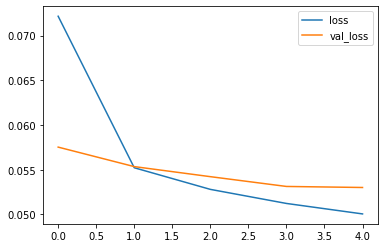

In [37]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

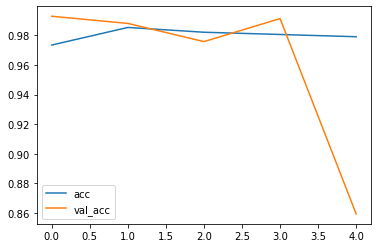

In [38]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [39]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9787147490642211
